<center> <h1> RATINGS: scRaping and AnalyzIng biTcoIN mininG poolS </h1></center>
<center> <h3> Leonardo Puosi Mat. 628393 </h3></center>

### Importazione delle librerie e dei dataset

Importo le librerie necessarie e carico i dataset relativi alle transazioni Bitcoin. Vengono letti tre file CSV:
- `inputs.csv` contenente gli input delle transazioni.
- `outputs.csv` contenente gli output delle transazioni.
- `transactions.csv` contenente le informazioni delle transazioni.

Ogni dataset viene caricato in un DataFrame di pandas.


In [82]:

import pandas as pd
import matplotlib.pyplot as plt
import requests
from fake_useragent import UserAgent
import random
from bs4 import BeautifulSoup
import time
import networkx as nx
import seaborn as sns
import re



inputs = pd.read_csv("Datasets/inputs.csv", names= ["txId", "prevTxId", "prevTxpos"])
outputs = pd.read_csv("Datasets/outputs.csv", names= ["txId", "position","addressId","amount","scripttype"])
transactions = pd.read_csv("Datasets/transactions.csv", names = ["timestamp", "blockId", "txId", "isCoinbase", "fee"])


<h1>Analisi dell'andamento delle fee rispetto alla congestione </h1>

<h2> Calcolo della congestione </h2>

### Filtraggio delle transazioni e unione dei dati

1. Creo il dataframe (`tx_filtered`) il quale contiene le transazioni che non sono Coinbase
2. Unisco i dati degli input (`inputs`) e degli output (`outputs`) con le informazioni di timestamp delle transazioni filtrate (`tx_filtered`), creando rispettivamente i DataFrame (`tx_inputs`) e (`tx_outputs`.)


In [83]:
tx_filtered= transactions[transactions.isCoinbase != 1].copy()                  

tx_inputs = inputs.merge(tx_filtered[['txId', 'timestamp']], on='txId')
tx_outputs = outputs.merge(tx_filtered[['txId', 'timestamp']], on='txId')


### Calcolo delle dimensioni delle transazioni

1. Utilizzo la funzione map per sostituire ad ogni valore della colonna `scripttype` la dimensione dello script utilizzato.

2. Utilizzo la funzione groupby su `txId` con la funzione di aggregazione size per calcolare per ogni transazione il rispettivo numero di address in input e in output.
    * (`tx_outputs`) contiene per ogni transazione, tanti record che hanno lo stesso valore sulla colonna `txId` quanti output sono presenti nella transazione, questo permette di raggruppare per `txId`.

3. Creo un nuovo Dataframe (`script_sizes_df`), il quale contiene per ogni transazione, la somma di tutti gli script utilizzati, ovvero `script_size`.

4. Effettuo il join tra (`tx_filtered`) e (`input_counts`) e (`output_counts`) in modo da associare ad ogni transazione il numero di input e output presenti.

5. Infine aggiungo a (`tx_filtered`) la dimensione degli script utilizzati, presente in (`script_sizes_df`) e utilizzo la formula fornita per calcolare `tx_size` di ogni transazione.




In [84]:
SIZE_INPUT = 40  # Dimensione media di un input in byte
SIZE_OUTPUT = 9  # Dimensione media di un output in byte

script_sizes = {0: 100, 1: 153, 2: 180, 3: 291}

tx_outputs['script_size'] = tx_outputs['scripttype'].map(script_sizes).fillna(0)

input_counts = tx_inputs.groupby('txId').size().reset_index(name='n_inputs')
output_counts = tx_outputs.groupby('txId').size().reset_index(name='n_outputs')

script_sizes_df = tx_outputs.groupby('txId')['script_size'].sum().reset_index(name='script_size')

tx_filtered = tx_filtered.merge(input_counts, on='txId', how='left').merge(output_counts, on='txId', how='left')            #per n_inputs e n_outputs


tx_filtered = tx_filtered.merge(script_sizes_df, on='txId', how='left')                                                     #per script_size

tx_filtered['tx_size'] = SIZE_INPUT * tx_filtered['n_inputs'] + SIZE_OUTPUT * tx_filtered['n_outputs'] + tx_filtered['script_size']         #per tx_size

tx_filtered.sample()

,timestamp,blockId,txId,isCoinbase,fee,n_inputs,n_outputs,script_size,tx_size
1711923,1321395359,153467,1865389,0,50000,1,2,360,418


<h2> Calcolo delle fee </h2>

### Analisi della congestione e delle fee

1. Converto la colonna `timestamp` del dataframe (`tx_filtered`) in formato datetime e la imposto come indice del dataframe, questo è necessario perchè la funzione resample richiede un DateTimeIndex.
2. Effettuo il downsampling con frequenza settimanale su `tx_size` ottenendo la congestione per ogni settimana del dataset in esame, e ripeto il procedimento per la colonna `fee`
3. Racchiudo i dati in un unico dataframe (`analysis`) e ne calcolo la correlazione
4. Utilizzo uno scatter plot per mostrare la correlazione tra congestione e fee


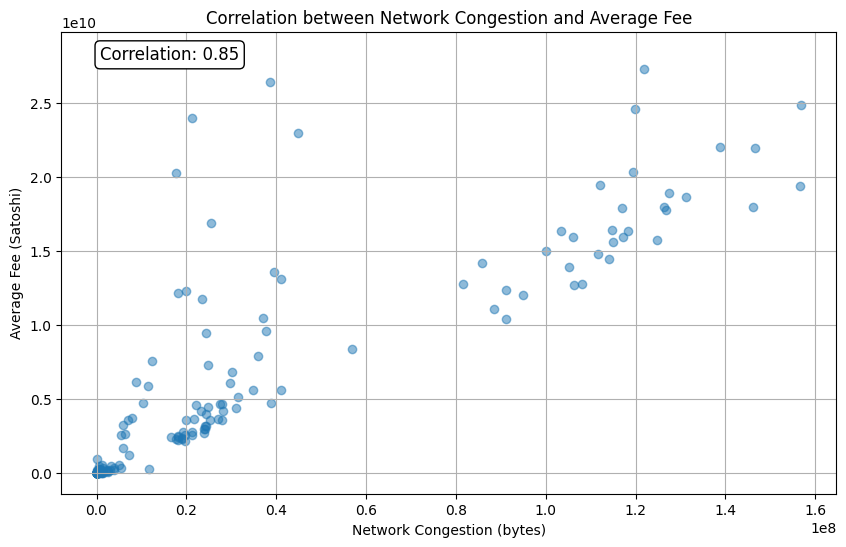

In [85]:

tx_filtered['timestamp'] = pd.to_datetime(tx_filtered['timestamp'], unit='s')

tx_filtered = tx_filtered.set_index("timestamp")

congestion = tx_filtered.resample('W')['tx_size'].sum().reset_index()
fee_avg = tx_filtered.resample('W')['fee'].sum().reset_index()

# Unisco la congestione e le fee
analysis = congestion.merge(fee_avg, on='timestamp')
analysis.columns = ['timestamp', 'congestion', 'average_fee']

# Calcolo il valore di correlazione
correlation = analysis['congestion'].corr(analysis['average_fee'])


plt.figure(figsize=(10, 6))
plt.scatter(analysis['congestion'], analysis['average_fee'], alpha=0.5)
plt.title('Correlation between Network Congestion and Average Fee')
plt.xlabel('Network Congestion (bytes)')
plt.ylabel('Average Fee (Satoshi)')
plt.grid(True)
plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='center',
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.show()



## Analisi tipi di script

1. Effettuo un join tra (`outputs`) e (`transactions`) con l'obbiettivo di affiancare ad ogni record di (`outputs`) il relativo timestamp
2. Evidenzio l'utilizzo totale di ogni script
3. Trasformo la colonna `timestamp` in datetime e la seleziono come indice del nuovo Dataframe

In [86]:
out = transactions.merge(outputs, how="right", on="txId")
print("Script di tipo 1:",len(out[out.scripttype == 1]))
print("Script di tipo 2:",len(out[out.scripttype == 2]))
print("Script di tipo 3:",len(out[out.scripttype == 3]))
print("Script di tipo 0:",len(out.query("scripttype == 0")))
out["timestamp"] = pd.to_datetime(out['timestamp'], unit="s")
out = out.set_index("timestamp")

Script di tipo 1: 707931
Script di tipo 2: 23899630
Script di tipo 3: 336
Script di tipo 0: 5906


## Distribuzione dei tipi di script nel tempo
1. Creo un nuovo Dataframe (`script_counts`) che contiene, per ogni tipo di script, il numero di volte che viene utilizzato nell'arco di due mesi.
    * Partendo da (`out`), effettuo un raggruppamento con frequenza bimestrale sulla colonna `scripttype`
    * Utilizzando la funzione size, calcolo per ogni periodo il numero di script utilizzati  
2. Per mostrare la distribuzione dei tipi di script nel tempo, ho utilizzato un Grouped Bar Plot con scala logaritmica in modo da evidenziare la relazione tra i vari tipi anzichè la quantità assoluta

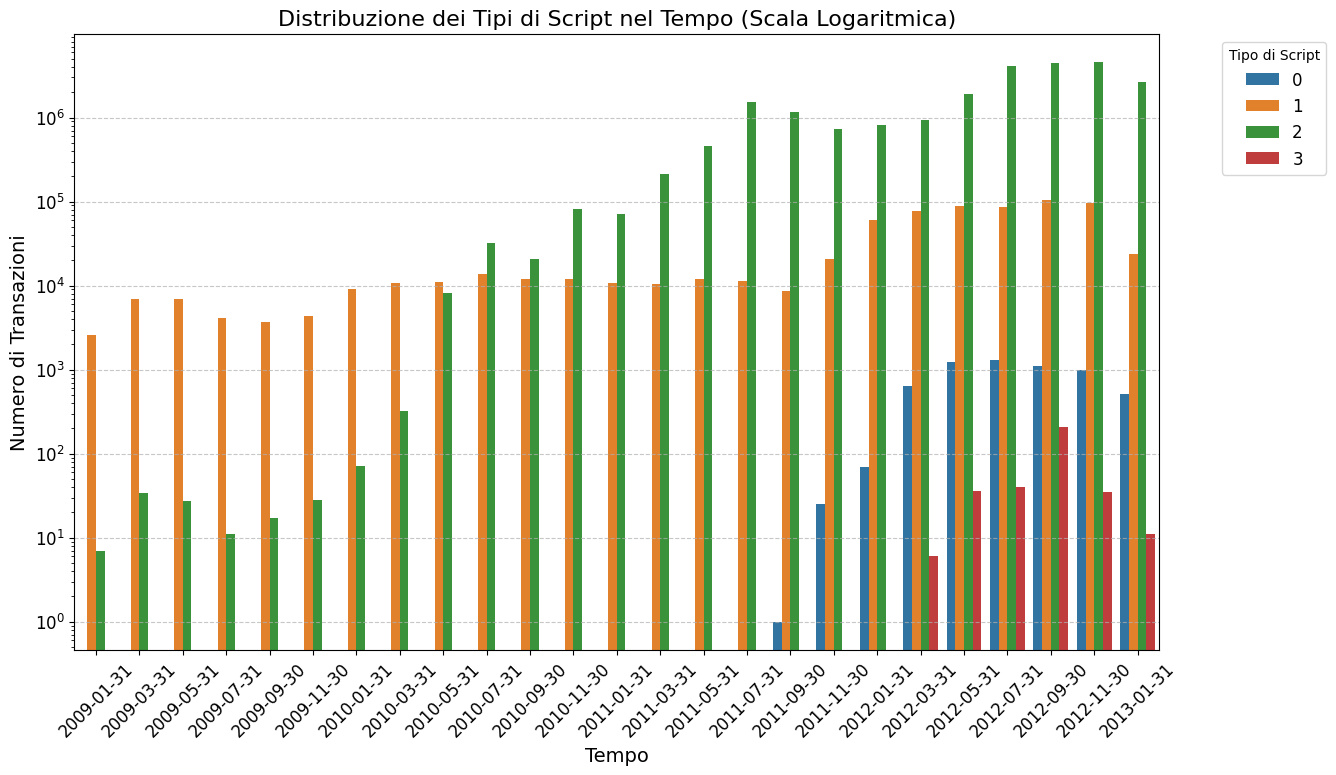

In [87]:

script_counts = out.groupby([pd.Grouper(freq='2ME'), 'scripttype']).size().reset_index(name = "Script")

plt.figure(figsize=(14, 8))

sns.barplot(data = script_counts, x="timestamp", y="Script", hue="scripttype", palette="tab10")
plt.yscale("log")

plt.title('Distribuzione dei Tipi di Script nel Tempo (Scala Logaritmica)', fontsize=16)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Numero di Transazioni', fontsize=14)
plt.legend(title='Tipo di Script', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Script_counts è strutturato in questo modo:

In [88]:
script_counts.head()

,timestamp,scripttype,Script
0,2009-01-31,1,2580
1,2009-01-31,2,7
2,2009-03-31,1,6886
3,2009-03-31,2,34
4,2009-05-31,1,6844


<h1>Analisi delle mining pool</h1>

### Scraping dei proxies da sslproxies.org

In [89]:

ua = UserAgent()
random_ua = ua.random


proxies = []
def generate_proxies():
    proxies.clear()
    proxies_doc = requests.get("https://www.sslproxies.org/")
    if(proxies_doc.status_code != 200):
        print("Errore durante lo scraping dei proxy")
        return 
    soup = BeautifulSoup(proxies_doc.text, 'html.parser')
    proxies_table = soup.find('table', class_='table table-striped table-bordered')
    # Salvo i proxy nella lista proxies
    for row in proxies_table.tbody.find_all('tr'):
        td = row.find_all('td')
        proxies.append({
        'ip':   td[0].string,
        'port': td[1].string})


generate_proxies()
print(f"Numero di proxy ottenuti da sslproxies.org: {len(proxies)}")


Numero di proxy ottenuti da sslproxies.org: 100


## Scraping degli address appartenenti ai Pool

table_parser è una funzione che ha come input una pagina dopo il parsing di BeautifulSoup e restituisce un DataFrame con la stessa struttura della tabella

In [90]:

def table_parser(soup):
    temp_df = pd.DataFrame(columns = ["address", "balance", "incoming_txs","last_block"])
    table = soup.find("table")
    righe = table.findAll("tr")
    for riga in righe:
        elementi = riga.findAll("td")
        if(len(elementi) == 4):
            riga_dataframe = [elementi[0].text.strip(), elementi[1].text.strip(), elementi[2].text.strip(),elementi[3].text.strip()]
            temp_df.loc[len(temp_df)] = riga_dataframe
    return temp_df


get_total_pages è una funzione che ha come input la prima pagina del Pool in esame e restituisce il numero di pagine su cui fare Crawling

In [91]:

def get_total_pages(soup):
    paging_div = soup.find("div", class_="paging")
    if paging_div:
        text = paging_div.get_text()
        page_info = text.split("Page")[1].split("/")[1].strip().split()[0]
        total_pages = int(page_info)
        return total_pages
    return 1

1. Scraper è una funzione che ha come input la prima pagina contenente gli addresses del pool in esame e restituisce il dataframe contenente tutti i dati relativi al pool
    * Creo un Dataframe temporaneo per memorizzare i dati ottenuti mediante scraping
    * Chiamo la funzione get_total_pages per ottenere il numero di pagine su cui fare crawling
    * Per ogni pagina, ripeto l'operazione di ricezione della pagina finchè non ottengo il codice 200 (OK), rimuovendo nel frattempo i proxies utilizzati
    * Nel caso in cui non riesca a terminare lo scraping dei dati, la funzione solleva un eccezione


In [92]:
def scraper(base_page):
    data = pd.DataFrame(columns=["address", "balance", "incoming_txs", "last_block"])
    soup = BeautifulSoup(base_page.text, 'html.parser')
    npages = get_total_pages(soup)
    user_agent = ua.random
    headers = {'User-Agent': user_agent}

    for i in range(npages):
        while True:
            if i == 0:
                page = base_page
            else:
                proxy = random.choice(proxies)
                page = requests.get(base_page.url + "?page=" + str(i + 1),headers=headers, proxies=proxy)
                time.sleep(1)

            if(page.status_code == 200):
                soup = BeautifulSoup(page.text, 'html.parser')
                data = pd.concat([data, table_parser(soup)], ignore_index=True)
                break
            else:
                print(page.status_code)
                proxies.remove(proxy)
                if(len(proxies) == 0): raise Exception("Errore durante la fase di Scraping")  
                time.sleep(10)
                continue

    return data  






1. Eseguo un ciclo for sui pool richiesti effettuando due richieste al sito
    * La prima richiesta è una query sul nome del pool, la quale restituisce la pagina contenente le transazioni del pool
    * La seconda richiesta aggiunge `/addresses` ottenendo la prima pagina contenente la tabella degli indirizzi associati al pool.
2. Ad ogni iterazione chiamo la funzione scraper e inserisco i risultati nel dataframe, aggiungendo la colonna `pool` per tenere traccia del pool di appartenenza
3. Come per la funzione scraper, sono presenti delle misure anti-scraping



In [93]:
base_url = "https://www.walletexplorer.com/?q="
pools = ['DeepBit','Eligius', 'BTCGuild', 'BitMinter']


# Inizializzo un dataframe vuoto per contenere tutti i dati
combined_df = pd.DataFrame(columns=["address", "balance", "incoming_txs", "last_block", "pool"])

for pool in pools:

    
    user_agent = ua.random
    headers = {'User-Agent': user_agent}

    while True:
        proxy = random.choice(proxies)
        r = requests.get(base_url + pool, headers=headers, proxies=proxy)
        if(r.status_code == 200):
            proxy = random.choice(proxies)
            address_page = requests.get(r.url + "/addresses",headers=headers, proxies=proxy)  # r.url contiene l'url della query
            time.sleep(2)
            df = scraper(address_page)
            df["pool"] = pool  # Aggiungo una colonna per indicare il pool di appartenenza
        
            combined_df = pd.concat([combined_df, df], ignore_index=True)
            break
        else:
            print(r.status_code)
            proxies.remove(proxy)
            if(len(proxies) == 0): raise Exception("Errore durante la fase di Scraping")
            time.sleep(10)
            continue   


1. Carico il dataset (`addr_map`) dal file .csv.
2. Creo un nuovo Dataframe (`deanonimizz`) effettuando un join tra i risultati della fase di scraping e (`addr_map`)
    * Seleziono solo gli address che sono presenti in entrambi i dataframe.
    * Associo ad ogni address ottenuto tramite scraping, la colonna `addressId` in modo da ottenere una corrispondenza con i dataset forniti

In [94]:
addr_map = pd.read_csv("Datasets/mapAddr2Ids8708820.csv", names=["hash", "addressId"])
addr_map['addressId'] = addr_map['addressId'].astype(str)

#seleziono solo gli address che sono presenti nella map, ovvero quelli relativi al periodo in esame
deanonimizz = addr_map.merge(combined_df, how="inner", left_on= "hash", right_on="address")                   
deanonimizz = deanonimizz[["hash","addressId","balance","incoming_txs","last_block","pool"]]
len(deanonimizz)

895

### Calcolo dei top 4 Miners

1. Creo un dataset (`tx_mined`) contenente solo le transazioni Coinbase
2. Creo un dataset (`tx_out`), dato dal join tra (`tx_mined`) e (`outputs`) in modo da associare alle transazioni, i vari `addressId`
3. Effettuo la differenza insiemistica tra (`tx_out`) e (`deanonimizz`) in modo da ottenere solo le transazioni che non fanno riferimento ai Pool analizzati precedentemente
    * Impostando indicator = True, ottengo una nuova colonna `_merge` che identifica a quale dataframe appartiene la riga.
    * (`tx_out_filtered`) contiene quindi le righe che sono presenti solo nel primo dataframe, rimuovendo l'intersezione tra i due.
4. Conto quante transazioni appartengono a ciascun `addressId` e seleziono i primi 4

In [95]:
# Filtro le transazioni Coinbase
tx_mined = transactions[transactions['isCoinbase'] == 1].copy()

# Unisco le transazioni Coinbase con gli output per ottenere gli indirizzi di destinazione
tx_out = tx_mined.merge(outputs, how='inner', on='txId', suffixes=('_tx', '_out'))

tx_out['addressId'] = tx_out['addressId'].astype(str)
deanonimizz['addressId'] = deanonimizz['addressId'].astype(str)


# Rimuovo le transazioni con indirizzi deanonimizzati
merged_df = tx_out.merge(deanonimizz[['addressId']], how='left', on='addressId', indicator=True)

# Filtro le righe che non sono presenti in deanomizz
tx_out_filtered = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# Conto il numero di transazioni per ciascun indirizzo
address_tx_count = tx_out_filtered['addressId'].value_counts().reset_index()
address_tx_count.columns = ['addressId', 'tx_count']

# Unisco con addr_map per ottenere gli hash
top_4 = address_tx_count.head(4).merge(addr_map, on='addressId', how='inner')
print(top_4)

  addressId  tx_count                                hash
0   3009769      2587  1811f7UUQAkAejj11dU5cVtKUSTfoSVzdm
1   4900375      1919  1Baf75Ferj6A7AoN565gCQj9kGWbDMHfN9
2   2485157      1741  1KUCp7YP5FP8ViRxhfszSUJCTAajK6viGy
3   7075826      1738  151z2eoe2D9f6cohGNNU96GsKAqLfYP8mN


### Scraping dei top 4 Miners
1. Applico la funzione addressLookup per ogni riga presente in (`top_4`)
2. Aggiungo la colonna `pool` per indicare l'identificativo dell'indirizzo deanonimizzato

In [96]:
query_url= "https://www.walletexplorer.com/?q="
def addressLookup(address):
    page = requests.get(query_url+address)
    soup = BeautifulSoup(page.text, "html.parser")
    elem = soup.find("h2").text.strip()
    wallet = elem.split(" ")
    return wallet[1]

 

In [97]:
top_4['pool'] = top_4['hash'].apply(addressLookup)
top_4.head()

,addressId,tx_count,hash,pool
0,3009769,2587,1811f7UUQAkAejj11dU5cVtKUSTfoSVzdm,[3e486bf1d3]
1,4900375,1919,1Baf75Ferj6A7AoN565gCQj9kGWbDMHfN9,EclipseMC.com-old
2,2485157,1741,1KUCp7YP5FP8ViRxhfszSUJCTAajK6viGy,[019a46b8d8]
3,7075826,1738,151z2eoe2D9f6cohGNNU96GsKAqLfYP8mN,[01a990df75]


In [98]:
#Associo ad ogni transazione le informazioni ottenute mediante scraping
tx_mined_pools = tx_out.merge(deanonimizz, how="inner", on= "addressId")        
tx_mined_top_4 = tx_out.merge(top_4, how="inner", on= "addressId")
tx_mined_pools.head()




,timestamp,blockId,txId,isCoinbase,fee,position,addressId,amount,scripttype,hash,balance,incoming_txs,last_block,pool
0,1297547632,107719,267383,1,0,0,227636,5000000000,1,1BnFQDEkXRmi4B9b39c2q7Ds54ZaMs3W4n,0.,1,110407,Eligius
1,1301649689,116105,383892,1,0,0,353828,5008000000,1,1JVG3fKSHVnGh2q5TrjUG8MNRYrSbnwFvv,0.,1,116606,Eligius
2,1303071269,118869,417030,1,0,0,395016,5000000000,1,18XA21sczeZkqrYYuQoN9KHQEQe2G2haJg,0.,1,119199,Eligius
3,1303898162,120476,444017,1,0,1,426688,1,2,1CT1Wbu5kkQArCkWjHnzKyx6YaPCiFTJdB,0.,1,126415,Eligius
4,1303982608,120630,447317,1,0,1,430715,16015804,2,1MG4smTeBeq2qdjfGbfRnmeJbycFiPKVGD,0.,6,126415,Eligius


1. Creo un nuovo Dataframe (`tx_mined_pools_unique`) rimuovendo da (`tx_mined_pools`) i record che hanno gli stessi valori su `pool` e `blockId`.
    * La partecipazione di un pool al mining del blocco è binaria, tengo solo conto se ha partecipato a minare quel blocco o no.
    * Rimuovendo i duplicati mi assicuro che il pool venga contato una sola volta anzichè tante volte quanti address ha utilizzato per ricevere la ricompensa. In caso contrario, se un pool ha partecipato al mining e ha diviso la ricompensa su n address diversi, otterrei che quel pool ha minato n blocchi, anzichè 1.
    * Anche se nel dataset fornito non si hanno blocchi minati da pool diversi (considerando i 4 presi in esame), eliminando i duplicati su `pool` e `blockid`, nel caso in cui due o più pool diversi abbiano partecipato al mining di uno stesso blocco, ottengo un record per ciascun pool.
2. Effettuo un downsampling con frequenza bimestrale per ogni pool, e ne calcolo la size, in modo da ottenere per ogni bimestre, il numero di blocchi minati da ogni pool
3. Ho utilizzato un Grouped Bar Plot (scala decimale e logaritmica) e un Line Plot per mostrare la distribuzione nel tempo.
    * Per mantenere consistenza nei colori tra i tre grafici, ho utilizato un dizionario
    * Per mostrare il line plot è necessario effettuare un'operazione di pivot
    

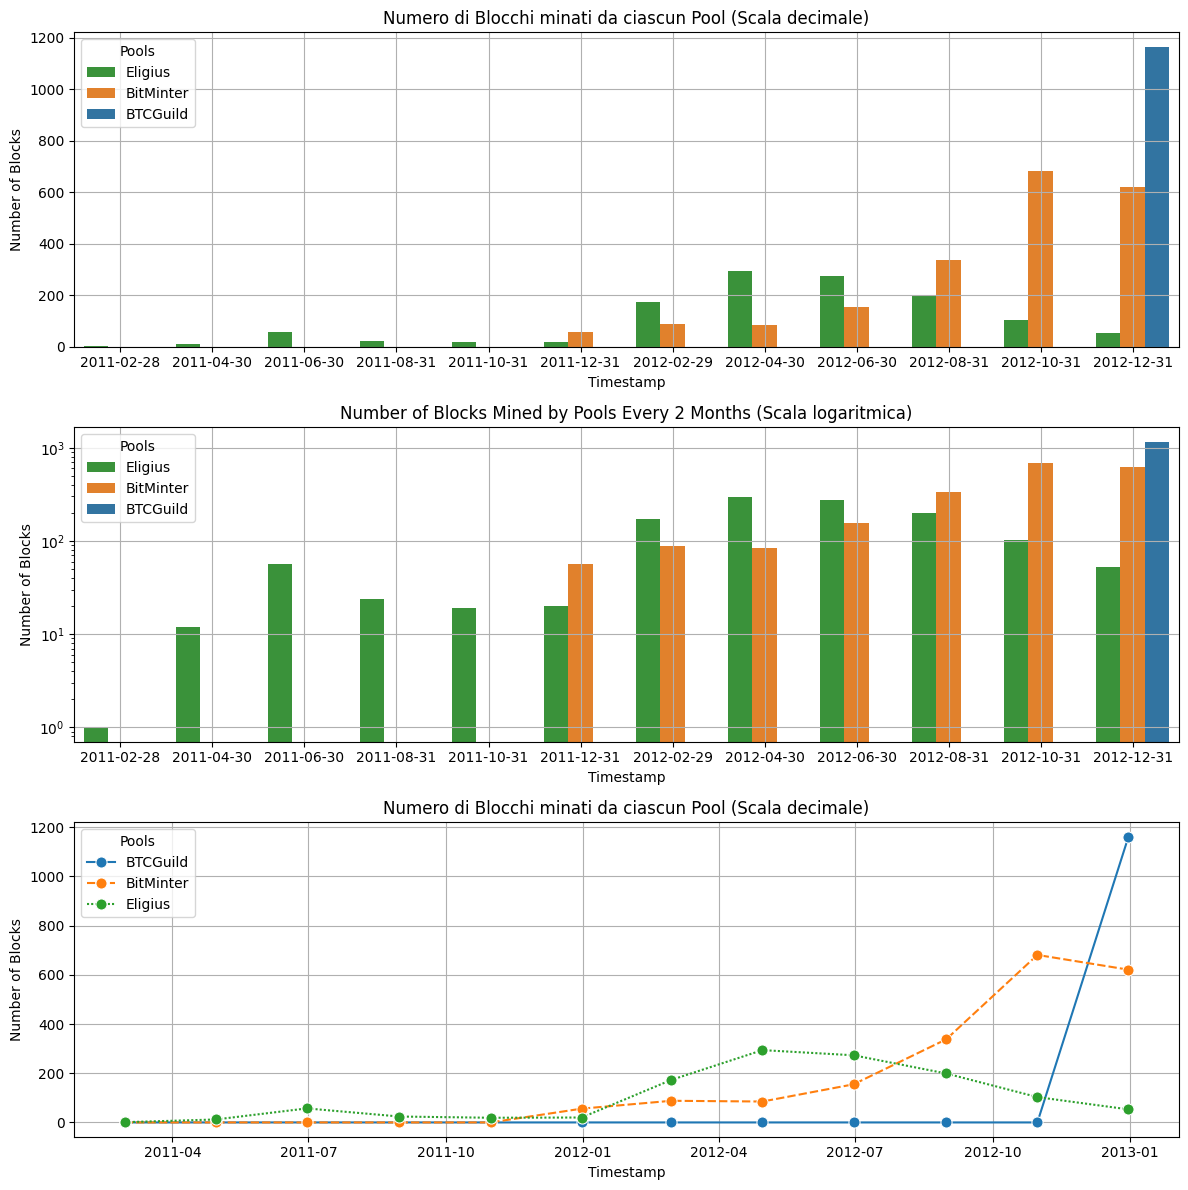

In [99]:

tx_mined_pools['timestamp'] = pd.to_datetime(tx_mined_pools['timestamp'], unit='s')

tx_mined_pools_unique = tx_mined_pools.drop_duplicates(subset=["pool", "blockId"])

# Resampling e aggregazione dei dati ogni 2 mesi
resampled_data = (
    tx_mined_pools_unique
    .set_index('timestamp')
    .groupby([pd.Grouper(freq='2ME'), 'pool'])
    .size()
    .reset_index(name='Blocks Mined')
)

pool_colors = {
    'BTCGuild': '#1f77b4',
    'BitMinter': '#ff7f0e',
    'Eligius': '#2ca02c',
}


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))


sns.barplot(data=resampled_data, x='timestamp', y='Blocks Mined', hue='pool', palette=pool_colors, ax=ax1)
ax1.set_title('Numero di Blocchi minati da ciascun Pool (Scala decimale)')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Number of Blocks')
ax1.legend(title='Pools')
ax1.grid(True)




sns.barplot(data=resampled_data, x='timestamp', y='Blocks Mined', hue='pool', palette=pool_colors, ax=ax2)
ax2.set_title('Number of Blocks Mined by Pools Every 2 Months (Scala logaritmica)')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Number of Blocks')
ax2.set_yscale("log")
ax2.legend(title='Pools')
ax2.grid(True)

resampled_data_pivot = resampled_data.pivot(index='timestamp', columns='pool', values='Blocks Mined').fillna(0)


sns.lineplot(data=resampled_data_pivot, ax=ax3, marker='o', markersize=8)
ax3.set_title('Numero di Blocchi minati da ciascun Pool (Scala decimale)')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Number of Blocks')
ax3.legend(title='Pools')
ax3.grid(True)

plt.tight_layout()
plt.show()


In [100]:
print("Numero di blocchi minati da ciascun pool:")
tx_mined_pools_unique.groupby("pool").size()


Numero di blocchi minati da ciascun pool:


pool
BTCGuild     1162
BitMinter    2024
Eligius      1228
dtype: int64

<h3>Top 4</h3>

1. Effettuo lo stesso procedimento per i top 4 miner 
2. In questo caso, non essendo specificati inizialmente i nomi dei top 4 miner ho utilizzato una palette dinamica per consistenza tra i grafici

C:\Users\puosi\AppData\Local\Temp\ipykernel_12180\942315105.py:44: UserWarning: 
The markers list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=resampled_data_pivot, ax=ax3, markers="o", palette=pool_colors)


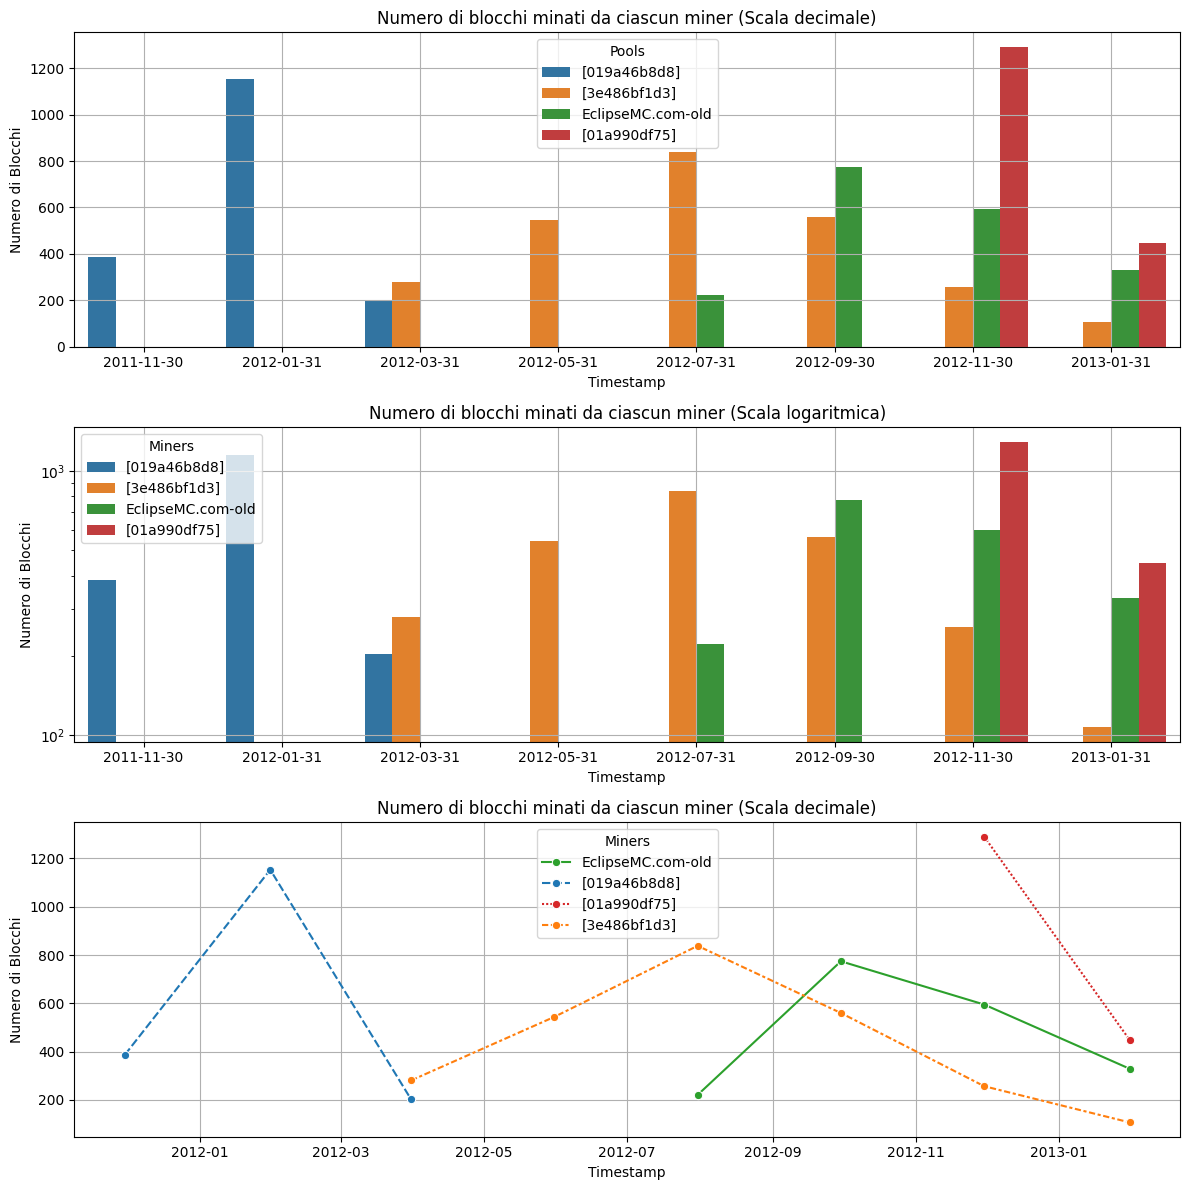

In [101]:

tx_mined_top_4['timestamp'] = pd.to_datetime(tx_mined_top_4['timestamp'], unit='s')


tx_mined_top_4_unique = tx_mined_top_4.drop_duplicates(subset=["pool", "blockId"])                      #non necessario nel dataset preso in esame ma presente per completezza
# Resampling e aggregazione dei dati ogni 2 mesi
resampled_data = (
    tx_mined_top_4_unique
    .set_index('timestamp')
    .groupby([pd.Grouper(freq='2ME'), 'pool'])
    .size()
    .reset_index(name='Blocks Mined')
)

# Generare una palette dinamica basata sul numero di pool unici (nel caso si richiedano più di 4 miners)
unique_pools = resampled_data['pool'].unique()
num_pools = len(unique_pools)
palette = sns.color_palette("tab10", num_pools)

#Creare un dizionario che mappa ciascun pool al suo colore
#zip restituisce una lista di tuple(pool, color)
pool_colors = {pool: color for pool, color in zip(unique_pools, palette)}


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

sns.barplot(data=resampled_data, x='timestamp', y='Blocks Mined', hue='pool', ax=ax1, palette=pool_colors)
ax1.set_title('Numero di blocchi minati da ciascun miner (Scala decimale)')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Numero di Blocchi')
ax1.legend(title='Pools')
ax1.grid(True)

sns.barplot(data=resampled_data, x='timestamp', y='Blocks Mined', hue='pool', ax=ax2, palette=pool_colors)
ax2.set_title('Numero di blocchi minati da ciascun miner (Scala logaritmica)')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Numero di Blocchi')
ax2.set_yscale("log")
ax2.legend(title='Miners')
ax2.grid(True)


resampled_data_pivot = resampled_data.pivot(index='timestamp', columns='pool', values='Blocks Mined')
sns.lineplot(data=resampled_data_pivot, ax=ax3, markers="o", palette=pool_colors)

ax3.set_title('Numero di blocchi minati da ciascun miner (Scala decimale)')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Numero di Blocchi')
ax3.legend(title='Miners')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [102]:
print("Numero di blocchi minati da ciascun pool:")
tx_mined_top_4_unique.groupby("pool").size()


Numero di blocchi minati da ciascun pool:


pool
EclipseMC.com-old    1919
[019a46b8d8]         1741
[01a990df75]         1738
[3e486bf1d3]         2587
dtype: int64

## Analisi della distribuzione delle reward ricevute da ogni mining pool

1. Creo un nuovo dataframe (`tx_rewards`) e converto il contenuto della colonna `amount` da Satoshi a BTC
2. Effettuo una pivot_table sul dataset in modo da ottenere la struttura corretta per il plot
    * Utilizzo pivot_table perchè potrebbero esserci delle combinazioni (timestamp, pool) duplicate (quando un pool appartiene più volte ad una transazione utilizando address diversi).
    * In questo caso, un'operazione di pivot non sapendo come gestire i duplicati fallirebbe.
    * Pivot_table invece utilizza la funzione di aggregazione in argomento sui record duplicati, questo comportamento non crea problemi perchè vengono accorpati solo record che appartengono allo stesso pool, risultando nella somma delle reward.
3. Effettuo il plot dei dati ottenuti mostrando sia in scala logaritmica che decimale

Text(0.5, 1.0, 'Reward ricevute da ogni pool (BTC)')

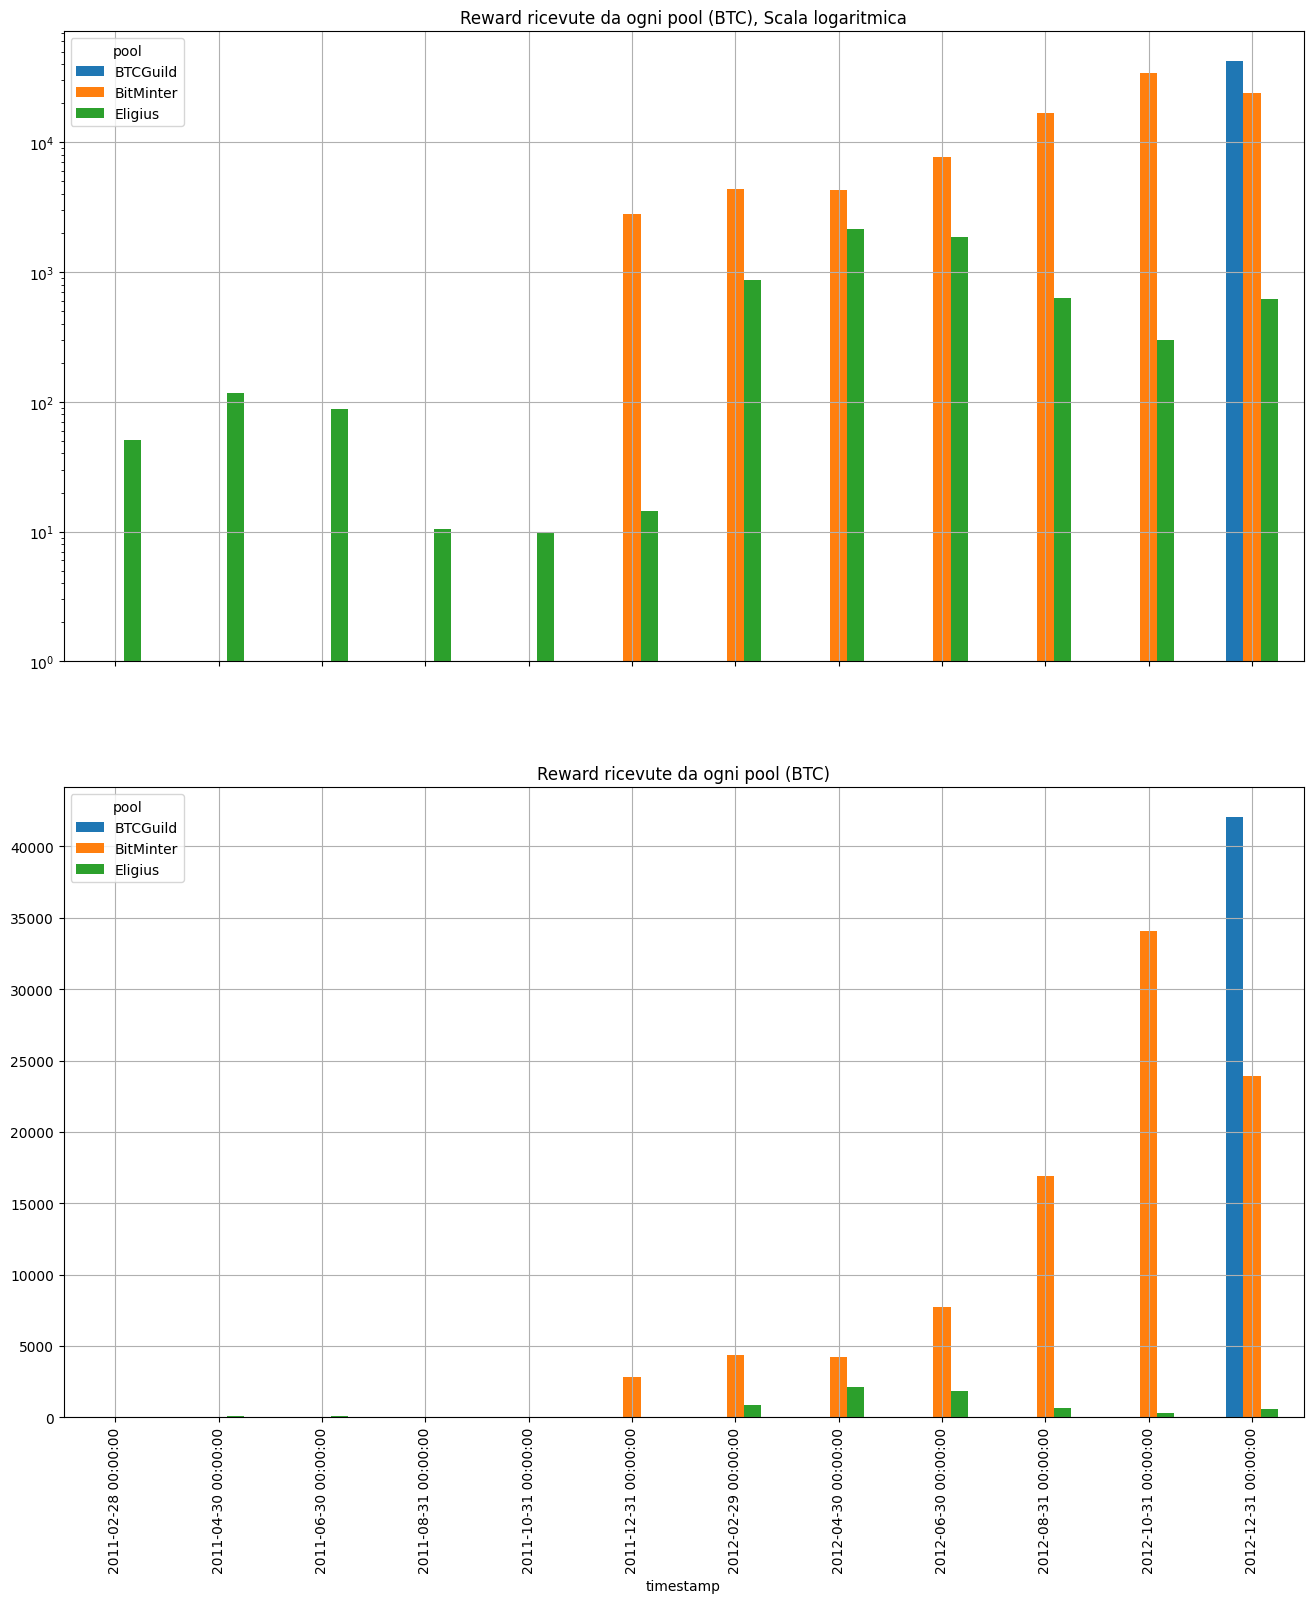

In [103]:
tx_rewards = tx_mined_pools.copy()   #utilizzo tx_mined_pools anzichè unique perchè al contrario di quando si analizzano il numero di blocchi minati, le reward ai pool possono variare nello stesso blocco
#Conversione da Satoshi a BTC
tx_rewards["amount"] = tx_rewards["amount"]/100000000   
tx_rewards = tx_rewards.pivot_table(index='timestamp', columns='pool', values='amount', aggfunc='sum')     
tx_rewards.head()

tx_rewards_resampled = tx_rewards.resample("2ME").sum()


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))


tx_rewards_resampled.plot(kind='bar', stacked=False, ax=ax1, log=True)
ax1.grid(True)

ax1.set_title("Reward ricevute da ogni pool (BTC), Scala logaritmica")
ax1.set_xlabel('')  #Rimuove l'asse x sotto il primo grafico
ax1.set_xticklabels([]) 

tx_rewards_resampled.plot(kind='bar', stacked=False, ax=ax2, log=False)
ax2.grid(True)
ax2.set_title("Reward ricevute da ogni pool (BTC)")





In [104]:
print("Reward ricevute da ogni mining pool (BTC)")
print(tx_rewards.sum())

Reward ricevute da ogni mining pool (BTC)
pool
BTCGuild     42036.491458
BitMinter    94132.813132
Eligius       6714.147688
dtype: float64


## Taint  Analysis
1. La funzione trace_bitcoin_flow riceve in input un address iniziale (in questo caso "Radix"), una transazione iniziale e la profondità massima
    * Crea un grafo MultiDiGraph e una lista di tuple per tenere traccia della profondità e per selezionare la prossima transazione
    * Viene chiamata la funzione get_transaction_outputs, e il risultato viene inserito nel grafo e nella lista
    * Si restituisce il grafo ottenuto
2. La funzione get_transaction_outputs riceve in input la transazione da analizzare, effettua lo scraping dei dati e inserisce i risultati in una lista di tuple
    * Per ottenere la quantità di BTC scambiati, utilizzo la funzione amount_parser che utilizza regex per estrarre il valore numerico

In [25]:

url="https://www.walletexplorer.com"

def amount_parser(s):
    # Utilizzo una regex per trovare numeri decimali (con o senza spazi e con o senza punti)
    match = re.search(r'(\d+(\.\d*)?|\.\d+)\s*BTC', s)
    if match:
        numero = float(match.group(1))  # Prendo il primo gruppo di numeri trovato
        return numero
    return None  


generate_proxies()
print(f"Numero di proxy ottenuti da sslproxies.org: {len(proxies)}")
tot_proxies= len(proxies)


def get_transaction_outputs(txid):
    outputs = []
    while True:
            proxy = random.choice(proxies)
            user_agent = ua.random
            headers = {'User-Agent': user_agent}
            time.sleep(random.randint(0, 2))                           
            page = requests.get(url+txid, headers=headers, proxies=proxy)
            if(page.status_code == 200):
                break
            else:
                #print("Time:",round(time.time() - start_time, 2),"Code:",page.status_code, "proxies rimanenti:", len(proxies))
                proxies.remove(proxy)
                if(len(proxies) == 0): raise Exception("Errore durante la fase di Scraping")
                time.sleep(5)
                continue
        
    
    soup = BeautifulSoup(page.text, "html.parser")
    table = soup.findAll("table", class_ = "empty")
    table_rows = table[1].findAll("tr")
    for row in table_rows:
        amount = row.findAll("td")[2]
        if(amount != None):
            amount = amount_parser(amount.text.strip())
        address = row.find("td").find("a")
        if(address == None):                                #unspent o indirizzo non trovato
            continue
        address = address.get("href")
        elem = row.find("td", class_="small")
        tx_new = elem.find("a")
        if(tx_new == None):                                #unspent o indirizzo non trovato
            continue
      
        tx_new = tx_new.get("href")
        outputs.append((address,tx_new, amount))


    return outputs

    
def trace_bitcoin_flow(start_address, start_txid, max_steps):
    G = nx.MultiDiGraph()  
    to_explore = [(start_address, start_txid, 0)]  # Lista di transazioni da esplorare con il loro livello di profondità
    
    while to_explore:
        current_address, current_txid, depth = to_explore.pop(0)  # Ottengo l'indirizzo e la transazione corrente con la loro profondità
        
        if depth >= max_steps:
            continue  
        
        outputs = get_transaction_outputs(current_txid)  
        
        for next_address, next_txid, amount in outputs:
            G.add_edge(current_address, next_address, txid=current_txid, amount=amount)  # Aggiungo un arco con l'importo come etichetta
            to_explore.append((next_address, next_txid, depth + 1))  # Aggiungo la prossima transazione da esplorare
    return G


start_txid = "/txid/c82c10925cc3890f1299407fa5da5d99cb6298fc43449b73c5cfdc75f28024f6"
start_address = 'Radix'
max_steps = 7
grafo = trace_bitcoin_flow(start_address, start_txid, max_steps)


Numero di proxy ottenuti da sslproxies.org: 100


### Spring Layout con 7 passi
Ad ogni nodo è assegnato un colore in base alla profondità

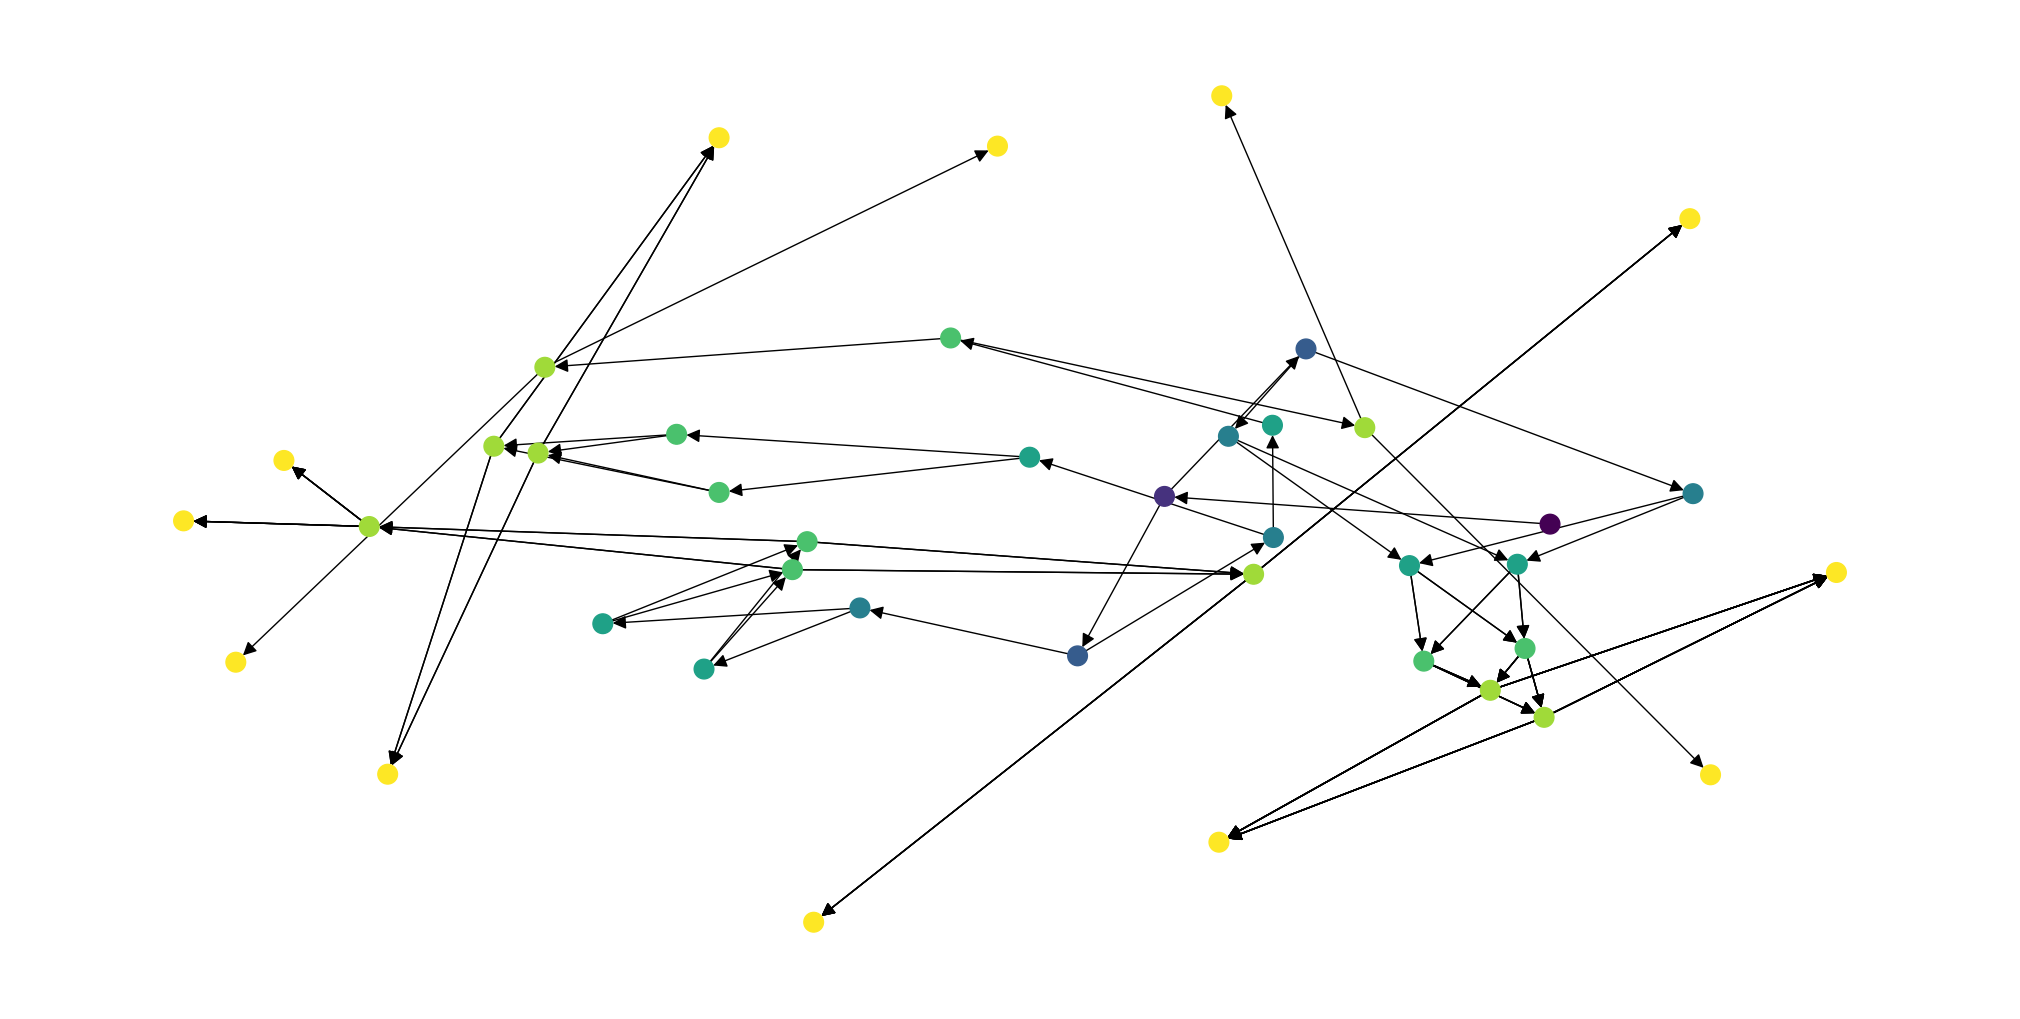

In [59]:
# Calcolo della profondità di ogni nodo usando BFS (Breadth-First Search)
depth = nx.single_source_shortest_path_length(grafo, start_address)

plt.figure(figsize=(20,10))
# Assegno un colore ad ogni nodo in base alla profondità
max_depth = max(depth.values())
colors = [plt.cm.viridis(depth[node] / max_depth) for node in grafo.nodes()]

pos = nx.spring_layout(grafo, seed = 10, k=0.5)
nx.draw(grafo, pos, node_color=colors, node_size=200, arrowsize=20)

plt.show()

### Planar layout con 7 passi

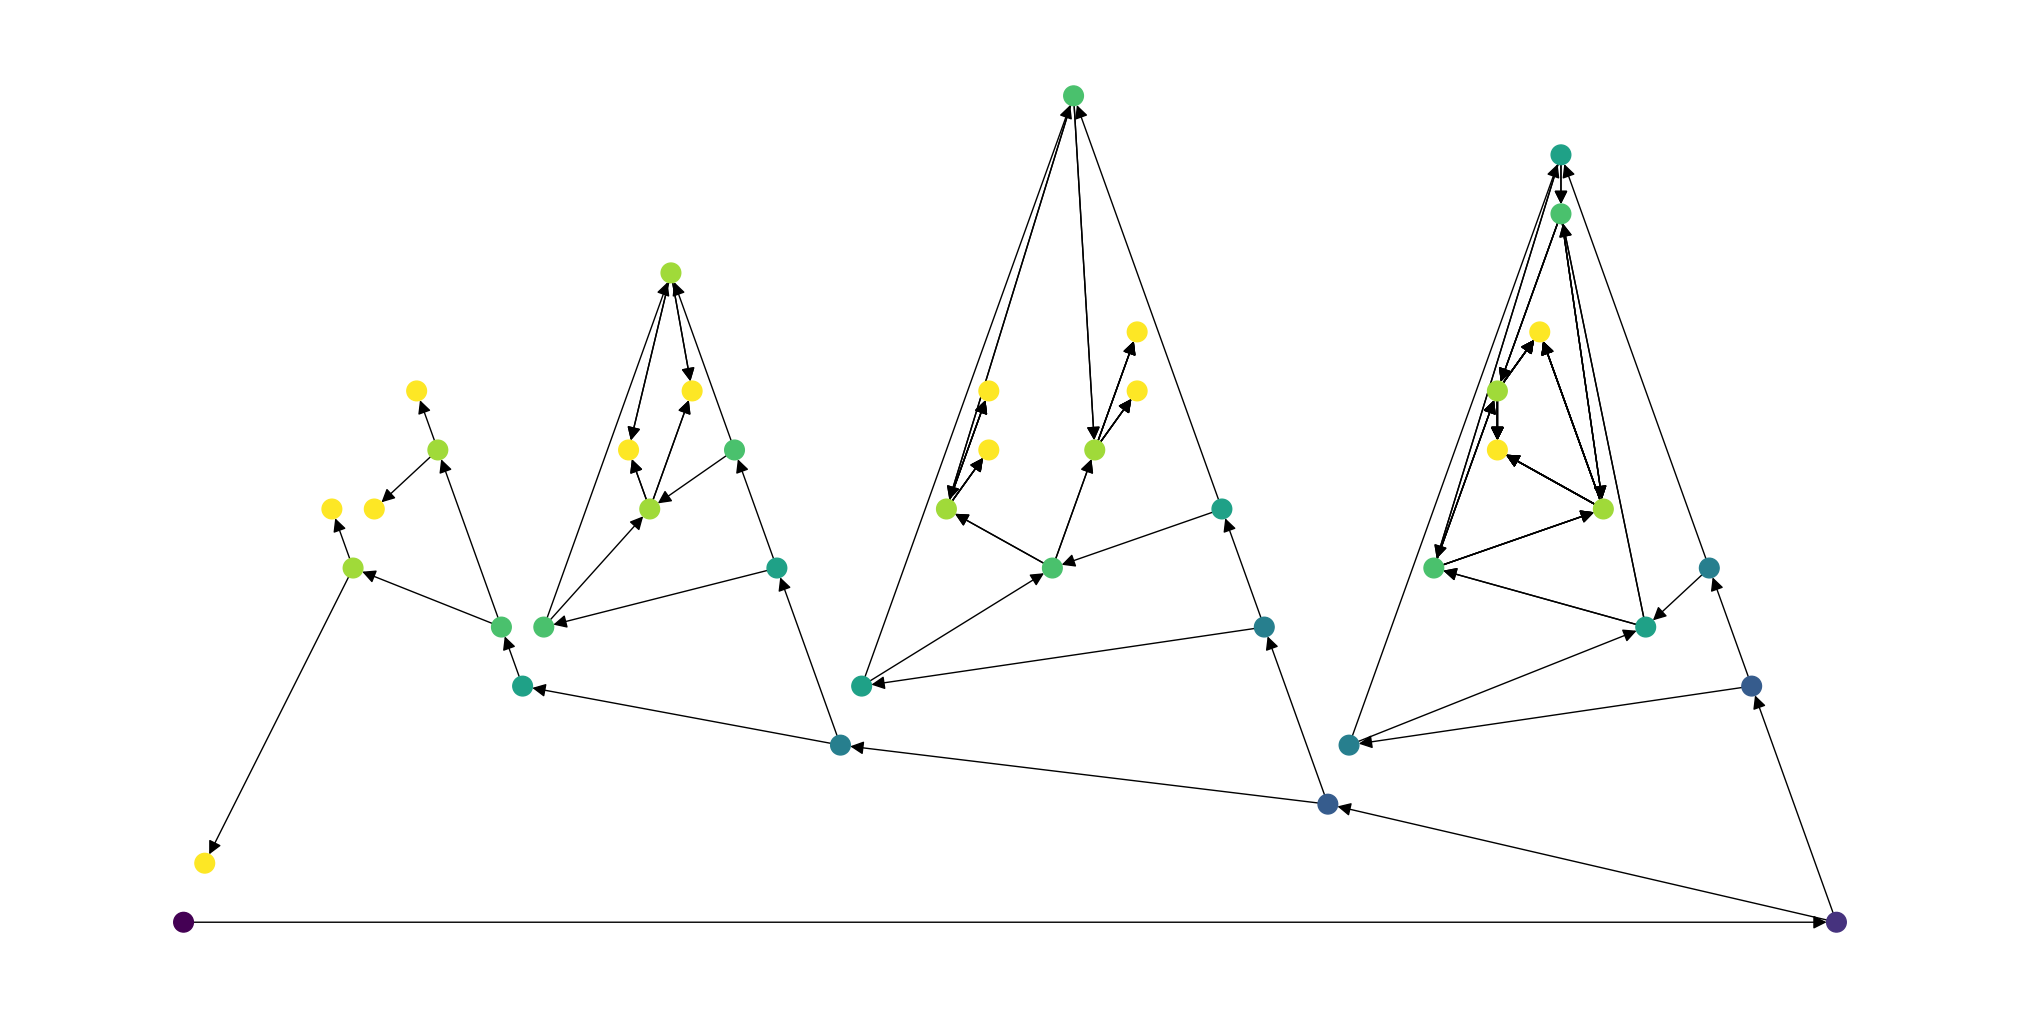

In [60]:

plt.figure(figsize=(20,10))
pos = nx.planar_layout(grafo)
nx.draw(grafo, pos, node_color=colors, node_size=200, arrowsize=20)

plt.show()

In [30]:
grafo2 = trace_bitcoin_flow(start_address, start_txid, 10)

### Kamada Kawai layout con 10 passi

Number of nodes: 115
Number of edges: 930


<Figure size 2000x1000 with 0 Axes>

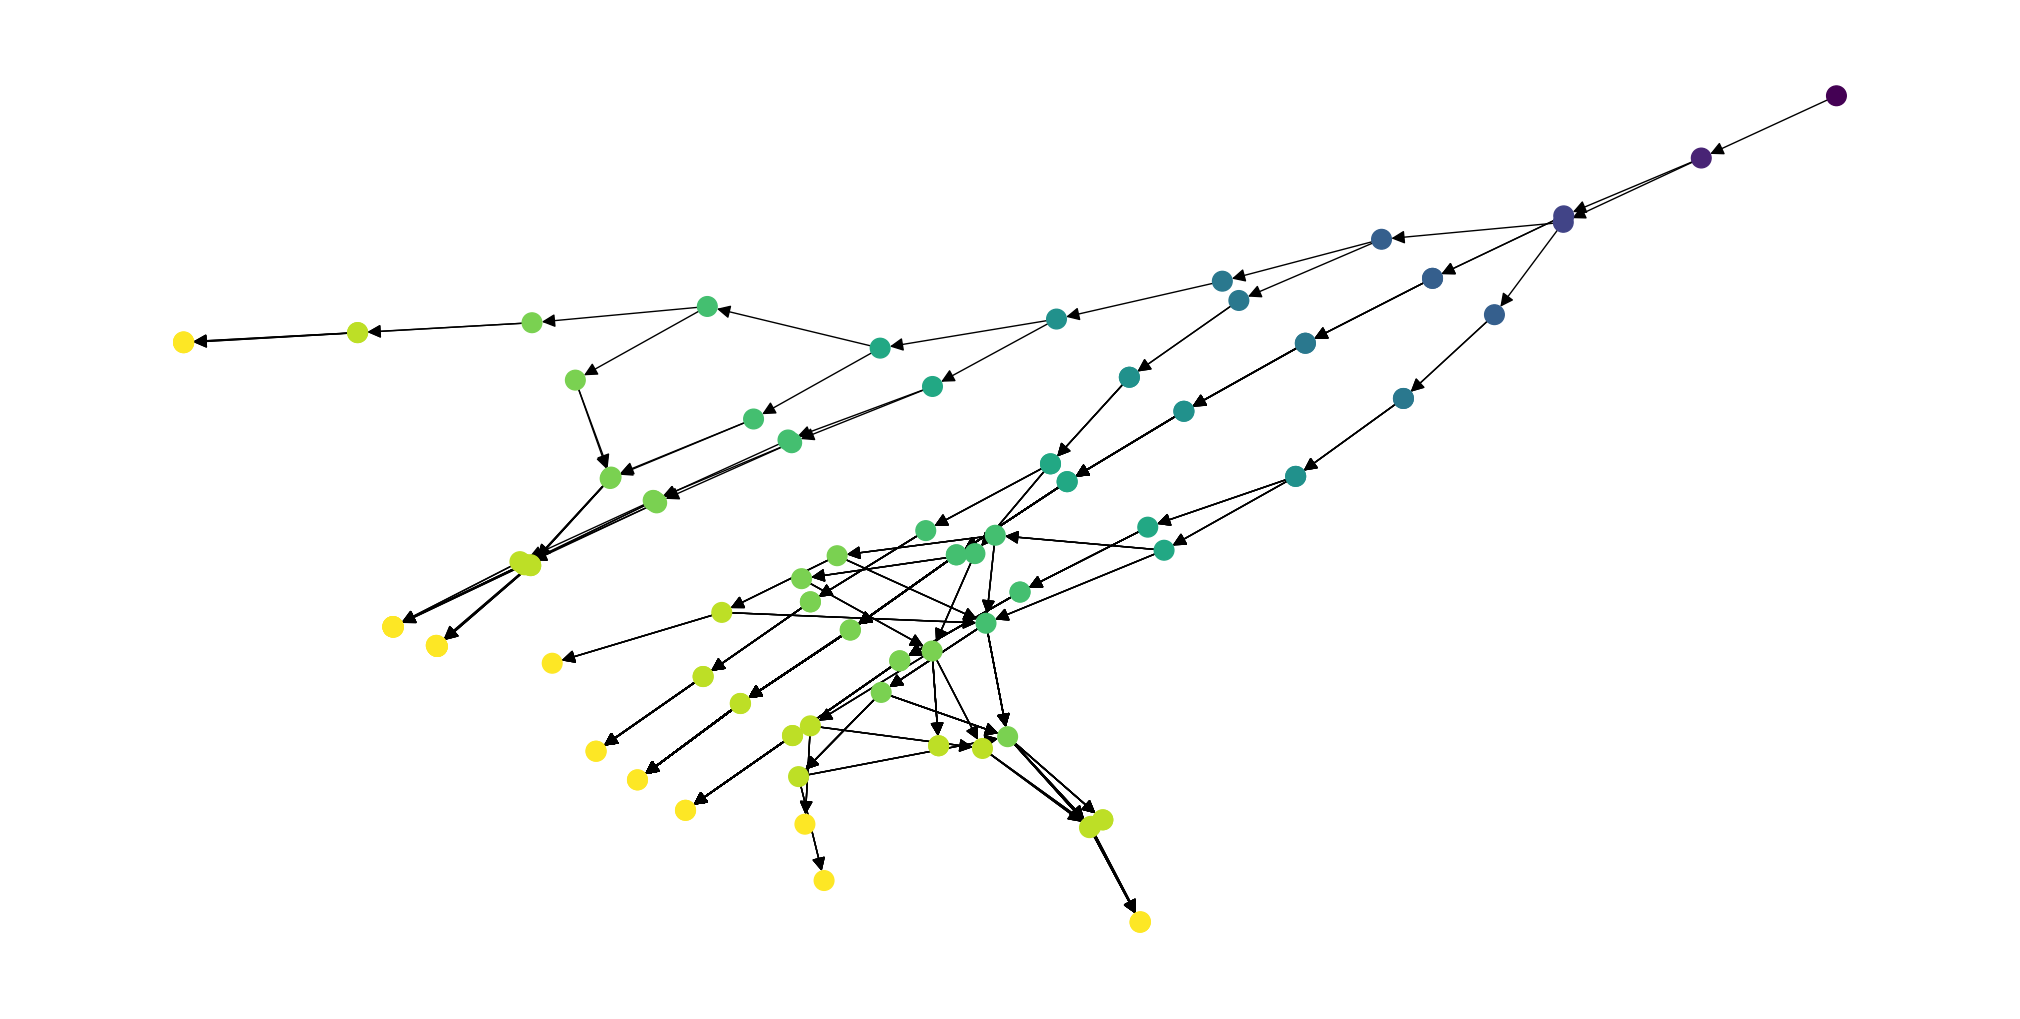

In [105]:
print("Number of nodes:", grafo2.number_of_nodes())
print("Number of edges:", grafo2.number_of_edges())
# Calcolo della profondità di ogni nodo usando BFS (Breadth-First Search)
depth2 = nx.single_source_shortest_path_length(grafo2, start_address)

plt.figure(figsize=(20,10))
# Assegno un colore ad ogni nodo in base alla profondità
max_depth2 = max(depth2.values())
colors2 = [plt.cm.viridis(depth2[node] / max_depth2) for node in grafo2.nodes()]

plt.figure(figsize=(20, 10))
pos = nx.kamada_kawai_layout(grafo2, scale = 2)
nx.draw(grafo2, pos, with_labels=False, node_size=200, node_color=colors2, font_size=10, font_weight="bold", arrowsize=20)

# Disegna le etichette degli archi con l'importo
edge_labels = {(u, v): f"{d['amount']} BTC" for u, v, d in grafo2.edges(data=True)}
#nx.draw_networkx_edge_labels(grafo, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5, rotate=False)
plt.show()